In [2]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [33]:
train_dir = 'train/train'
test_dir = 'unlabeled test/test1'
img_size = 50
lr = 1e-3

In [17]:
model_name = f'dogvcat_cnn-{img_size}-12conv'

In [18]:
def image_labeler(img):
    word_label = img.split('.')[0][0:3]
    if word_label == 'cat': 
        return [1,0]
    elif word_label == 'dog':
        return [0,1]

In [19]:
def create_training_data():
    training_data = []
    for img in tqdm(os.listdir(train_dir)):
        label = image_labeler(img)
        path = os.path.join(train_dir,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('training_data.npy',training_data)
    return training_data

In [20]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        testing_data.append([np.array(img),img_num])
    np.save('test_data.npy',testing_data)
    return testing_data


In [21]:
#train_data = create_training_data()
train_data = np.load('training_data.npy',allow_pickle=True)

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:37<00:00, 256.64it/s]


In [22]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf

tf.compat.v1.reset_default_graph()

convnet = input_data(shape=[None, img_size, img_size, 1], name='input')

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=lr, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir = 'log')


In [9]:
if os.path.exists(f'{model_name}.meta'):
    model.load(model_name)
    print('model_loaded')

In [23]:
train = train_data[:-500]
test = train_data[-500:]

In [24]:
X = np.array([i[0] for i in train]).reshape(-1, img_size,img_size,1)
Y = np.array([i[1] for i in train])

In [25]:
test_x = np.array([i[0] for i in test]).reshape(-1, img_size,img_size,1)
test_y = np.array([i[1] for i in test])

In [26]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
          snapshot_step=500, show_metric=True, run_id=model_name)


Training Step: 1914  | total loss: 0.52564 | time: 84.037s
| Adam | epoch: 005 | loss: 0.52564 - acc: 0.7407 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.51868 | time: 85.259s
| Adam | epoch: 005 | loss: 0.51868 - acc: 0.7541 | val_loss: 0.55373 - val_acc: 0.7120 -- iter: 24500/24500
--


In [27]:
i = 0
while i < 5:
    model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
              snapshot_step=500, show_metric=True, run_id=model_name)
    i+=1
    print(i)


Training Step: 11489  | total loss: 0.12655 | time: 77.647s
| Adam | epoch: 030 | loss: 0.12655 - acc: 0.9490 -- iter: 24448/24500
Training Step: 11490  | total loss: 0.12183 | time: 78.852s
| Adam | epoch: 030 | loss: 0.12183 - acc: 0.9510 | val_loss: 0.81614 - val_acc: 0.8060 -- iter: 24500/24500
--


In [36]:
model.save(model_name)

INFO:tensorflow:C:\Users\emil_\dogvcat_cnn-50-12conv is not in all_model_checkpoint_paths. Manually adding it.


In [34]:
test_data = process_test_data()
#test_data = np.load('test_data.npy')

100%|████████████████████████████████████████| 12500/12500 [00:19<00:00, 649.30it/s]


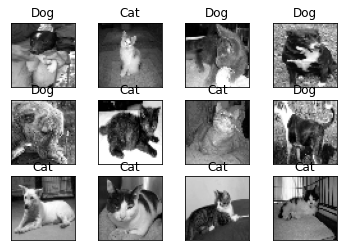

In [35]:
fig = plt.figure()

for num,data in enumerate(test_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(img_size,img_size,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1:
        str_label = 'Dog'
    else: 
        str_label = 'Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()